In [2]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches
!pip install tqdm --upgrad
!pip install pytesseract huggingface-hub transformers datasets seqeval tensorboard evaluate
import tensorflow as tf
import json
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
!pip install tensorflow-hub
!pip install -q datasets
!pip install transformers[torch]
!pip install accelerate -U`


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

ambiguous option: --upgrad (--upgrade, --upgrade-strategy?)
/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
label2id = {
    'Address': 0,
    'Company': 1,
    'Date': 2,
    'Item': 3,
    'Price': 4,
    'Quantity': 5,
    'Receiptnumber': 6,
    'Taxid': 7,
    'Telephone': 8,
    'Text': 9,
    'Title': 10,
    'Total': 11
}
label2id['Text']

9

In [ ]:
def Load_to_Dataframe(FileName,DataframeName):
  # Parse the JSON data
  with open(FileName, "r") as f:
      data = json.load(f)
  # Create a list to hold the preprocessed data
  preprocessed_data = []
  # Loop through the data
  for item in data:
      # Load the image from the OCR path
      image_path = item["ocr"]
      new_path = image_path.replace("/data/local-files?d=", "/content/drive/MyDrive/")
      #image = Image.open(new_path)
      # Then, we need to resize and crop the image to the desired dimensions
      #image = image.resize((224, 224)) # You can change the size according to your model's input
      # Now, we need to convert the image to a numpy array and normalize it
      #image = np.array(image) # This will convert the image to a 3D array of shape (224, 224, 3)
      #image = image / 255.0 # This will normalize the pixel values to the range [0, 1]
      # Read the image as a numpy array
      #image = cv2.imread(new_path)
      # Convert the image to grayscale
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # Resize the image to a fixed size
      #image = cv2.resize(image, (224, 224))
      # Flatten the image to a 1D array
      #image = image.flatten()
      image = new_path

      # Initialize lists to store bounding boxes, labels, and transcriptions
      bounding_boxes = []
      labels = []
      transcriptions = []

      # Loop through the bounding boxes
      for bbox_item, label_item, transcription_item in zip(
          item["bbox"], item["label"], item["transcription"]
      ):
          # Extract bbox coordinates
          x1 = bbox_item["x"]
          y1 = bbox_item["y"]
          width = bbox_item["width"]
          height = bbox_item["height"]
          original_width = bbox_item["original_width"]
          original_height= bbox_item["original_height"]
          # Calculate x2 and y2
          x2 = x1 + width
          y2 = y1 + height

          # Extract labels
          label = label_item["labels"][0]

          # Extract transcriptions
          transcription = transcription_item

          # Append bbox, label, and transcription to respective lists
          #bounding_boxes.append([x1 / original_width, y1 / original_height, x2 /original_width, y2 / original_height])
          bounding_boxes.append([x1 , y1, x2, y2])
          print()
          labels.append(label2id[label])
          transcriptions.append(transcription)

      # Create a dictionary for the preprocessed data

      preprocessed_item = {
          "image": image,  # You can use the PIL image directly
          "bounding_boxes": bounding_boxes,
          "labels": labels,
          "transcriptions": transcriptions,
      }

      # Append the preprocessed item to the list
      preprocessed_data.append(preprocessed_item)
  globals()[DataframeName] = pd.DataFrame(preprocessed_data)


In [ ]:
 Load_to_Dataframe("/content/drive/MyDrive/SROIE2019/Result.json","Resultdata")
 Load_to_Dataframe("/content/drive/MyDrive/SROIE2019/Test.json","Testdata")

In [ ]:
from datasets import Dataset as Dt
datasetresult = Dt.from_pandas(Resultdata)
datasettest = Dt.from_pandas(Testdata)

In [ ]:
import numpy as np
flat_labels = [item for sublist in datasetresult['labels'] for item in sublist]
unique_labels = np.unique(flat_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
label_list = unique_labels

label2id = {value:key  for key, value in label2id.items()}
id2label = [label2id[label] for id, label in enumerate(label_list)]

print(label2id)
print(id2label)


{0: 'Address', 1: 'Company', 2: 'Date', 3: 'Item', 4: 'Price', 5: 'Quantity', 6: 'Receiptnumber', 7: 'Taxid', 8: 'Telephone', 9: 'Text', 10: 'Title', 11: 'Total'}
['Address', 'Company', 'Date', 'Item', 'Price', 'Quantity', 'Receiptnumber', 'Taxid', 'Telephone', 'Text', 'Title', 'Total']


In [ ]:
label_list =  id2label
label_list

['Address',
 'Company',
 'Date',
 'Item',
 'Price',
 'Quantity',
 'Receiptnumber',
 'Taxid',
 'Telephone',
 'Text',
 'Title',
 'Total']

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from transformers import AutoTokenizer
from PIL import Image
from torch.utils.data import Dataset

tokenizer = AutoTokenizer.from_pretrained("nielsr/lilt-xlm-roberta-base")


def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # get item
    example = self.dataset[idx]
    image = example["image"]
    words = example["transcriptions"]
    boxes = example["bounding_boxes"]
    ner_tags = example["labels"]

    # prepare for the model
    img = Image.open(image)
    width, height = img.size
    bbox = []
    labels = []
    for word, box, label in zip(words, boxes, ner_tags):
        box = normalize_bbox(box, width, height)
        n_word_tokens = len(tokenizer.tokenize(word))
        bbox.extend([box] * n_word_tokens)
        labels.extend([label] + ([-100] * (n_word_tokens - 1)))

    cls_box = sep_box = [0, 0, 0, 0]
    bbox = [cls_box] + bbox + [sep_box]
    labels = [-100] + labels + [-100]

    encoding = self.tokenizer(" ".join(words), truncation=True, max_length=512)
    sequence_length = len(encoding.input_ids)
    # truncate boxes and labels based on length of input ids
    labels = labels[:sequence_length]
    bbox = bbox[:sequence_length]

    encoding["bbox"] = bbox
    encoding["labels"] = labels

    return encoding

train_dataset = CustomDataset(datasetresult, tokenizer)
eval_dataset = CustomDataset(datasettest, tokenizer)

In [ ]:
example = train_dataset[0]
tokenizer.decode(example["input_ids"])

'<s> 3180303 LIAN HING STATIONERY SDN BHD (162761-M) NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN GST ID : 002139201536 TAX INVOICE 27/03/2018 NO : CS-20243 QTY TAX RM F/CASTELL 187057- 75 TACK-LT 2 SR 12.00 TOTAL AMT INCL. GST @ 6% : 12.00 ROUNDING ADJUSTMENT : TOTAL AMT PAYABLE : 12.00 PAID AMOUNT : 20.00 CHANGE : 8.00 TOTAL QTY TENDER : 2 GST SUMMARY AMOUNT TAX (RM) (RM) SR @ A 11.32 0.68 TOTAL 11.32 0.68 THANK YOU FOR ANY ENQUIRY, PLEASE CONTACT US: 75G- WHITE (NEW) @ 5.6600</s>'

In [ ]:
for k,v in example.items():
  print(k,len(v))

input_ids 219
attention_mask 219
bbox 219
labels 219


In [ ]:
datasetresult["transcriptions"][0]

['3180303',
 'LIAN HING STATIONERY SDN BHD',
 '(162761-M)',
 'NO.32 & 33, JALAN SR 1/9, SEKSYEN 9,',
 'TAMAN SERDANG RAYA,',
 '43300 SERI KEMBANGAN, SELANGOR',
 'DARUL EHSAN',
 'GST ID : 002139201536',
 'TAX INVOICE',
 '27/03/2018',
 'NO : CS-20243',
 'QTY',
 'TAX',
 'RM',
 'F/CASTELL 187057- 75 TACK-LT',
 '2',
 'SR',
 '12.00',
 'TOTAL AMT INCL. GST @ 6% :',
 '12.00',
 'ROUNDING ADJUSTMENT :',
 'TOTAL AMT PAYABLE :',
 '12.00',
 'PAID AMOUNT :',
 '20.00',
 'CHANGE :',
 '8.00',
 'TOTAL QTY TENDER :',
 '2',
 'GST SUMMARY',
 'AMOUNT',
 'TAX',
 '(RM)',
 '(RM)',
 'SR @ A',
 '11.32',
 '0.68',
 'TOTAL',
 '11.32',
 '0.68',
 'THANK YOU',
 'FOR ANY ENQUIRY, PLEASE CONTACT US:',
 '75G- WHITE (NEW) @ 5.6600']

In [ ]:
for word, box, label in zip(datasetresult["transcriptions"][0], datasetresult["bounding_boxes"][0], datasetresult["labels"][0]):
  print(word, box, id2label[label])


3180303 [2.9079159935379644, 1.9428571428571428, 21.324717285945074, 4.685714285714286] Receiptnumber
LIAN HING STATIONERY SDN BHD [24.878836833602584, 15.314285714285715, 76.09046849757674, 17.6] Company
(162761-M) [42.32633279483037, 18.057142857142857, 58.48142164781906, 20.457142857142856] Text
NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, [21.486268174474958, 20.8, 79.32148626817448, 22.97142857142857] Address
TAMAN SERDANG RAYA, [31.502423263327948, 23.2, 69.46688206785137, 25.485714285714284] Address
43300 SERI KEMBANGAN, SELANGOR [21.324717285945074, 25.714285714285715, 78.9983844911147, 28.228571428571428] Address
DARUL EHSAN [39.5799676898223, 28.571428571428573, 61.873990306946695, 30.62857142857143] Address
GST ID : 002139201536 [30.37156704361874, 31.314285714285713, 70.75928917609048, 33.82857142857143] Taxid
TAX INVOICE [40.54927302100162, 35.2, 60.25848142164782, 37.714285714285715] Text
27/03/2018 [18.578352180936996, 38.51428571428571, 34.24878836833602, 40.57142857142857] Dat

In [ ]:
len(example["input_ids"])

219

In [ ]:
for id, box, label in zip(example["input_ids"], example["bbox"], example["labels"]):
  if label != -100:
    print(tokenizer.decode([id]), box, id2label[label])
  else:
    print(tokenizer.decode([id]), box, -100)


<s> [0, 0, 0, 0] -100
3 [4, 2, 34, 5] Receiptnumber
180 [4, 2, 34, 5] -100
30 [4, 2, 34, 5] -100
3 [4, 2, 34, 5] -100
L [40, 17, 122, 20] Company
IAN [40, 17, 122, 20] -100
 [40, 17, 122, 20] -100
HING [40, 17, 122, 20] -100
ST [40, 17, 122, 20] -100
ATION [40, 17, 122, 20] -100
E [40, 17, 122, 20] -100
RY [40, 17, 122, 20] -100
S [40, 17, 122, 20] -100
DN [40, 17, 122, 20] -100
B [40, 17, 122, 20] -100
HD [40, 17, 122, 20] -100
(16 [68, 20, 94, 23] Text
27 [68, 20, 94, 23] -100
61 [68, 20, 94, 23] -100
- [68, 20, 94, 23] -100
M [68, 20, 94, 23] -100
) [68, 20, 94, 23] -100
NO [34, 23, 128, 26] Address
. [34, 23, 128, 26] -100
32 [34, 23, 128, 26] -100
& [34, 23, 128, 26] -100
33 [34, 23, 128, 26] -100
, [34, 23, 128, 26] -100
J [34, 23, 128, 26] -100
ALAN [34, 23, 128, 26] -100
SR [34, 23, 128, 26] -100
1 [34, 23, 128, 26] -100
/9 [34, 23, 128, 26] -100
, [34, 23, 128, 26] -100
SEK [34, 23, 128, 26] -100
S [34, 23, 128, 26] -100
YEN [34, 23, 128, 26] -100
9 [34, 23, 128, 26] -100
, [3

In [ ]:
import torch
from torch.utils.data import DataLoader
def collate_fn(features):
  boxes = [feature["bbox"] for feature in features]
  labels = [feature["labels"] for feature in features]
  # use tokenizer to pad input_ids
  batch = tokenizer.pad(features, padding="max_length", max_length=512)
  sequence_length = torch.tensor(batch["input_ids"]).shape[1]

  batch["labels"] = [labels_example + [-100] * (sequence_length - len(labels_example)) for labels_example in labels]
  batch["bbox"] = [boxes_example + [[0, 0, 0, 0]] * (sequence_length - len(boxes_example)) for boxes_example in boxes]
  # convert to PyTorch
  # batch = {k: torch.tensor(v, dtype=torch.int64) if isinstance(v[0], list) else v for k, v in batch.items()}
  print(batch.items())
  batch = {k: torch.tensor(v) for k, v in batch.items()}
  return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
eval_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

batch = next(iter(train_dataloader))

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_items([('input_ids', [[0, 69436, 5, 391, 5, 568, 5, 1723, 5, 15, 594, 16, 159, 51671, 335, 16291, 15, 9688, 5, 153189, 152, 382, 161025, 15770, 9, 397, 16, 6, 115447, 48179, 20268, 284, 619, 48179, 20268, 571, 4, 821, 80855, 341, 57842, 305, 4, 6, 218269, 35429, 8168, 226750, 9330, 8678, 88507, 32462, 4, 6260, 7739, 159, 46565, 12182, 12689, 65988, 4, 6755, 73386, 24638, 15, 724, 8545, 11338, 9520, 152, 9508, 1197, 4598, 139911, 69622, 15, 26214, 65727, 8168, 61458, 724, 37026, 335, 19229, 284, 627, 28996, 4, 26289, 54390, 16, 20, 7783, 1542, 5881, 23256, 31722, 9, 78026, 284, 137990, 6, 120844, 9, 97544, 4904, 45334, 39456, 661, 294, 11666, 9016, 16291, 6746, 8316, 20, 2358, 2510, 189485, 2839, 201, 1193, 615, 22377, 2861, 2485, 87, 94885, 132, 294, 16, 152, 106, 2396, 27143, 132, 294, 16, 152, 201, 9926, 30487, 108416, 866, 5, 159424, 12174, 2861, 2485, 19452, 34384, 23186, 62, 100679, 67699, 33827, 20, 25656, 6, 182149, 9926, 30487, 19452, 211210, 397, 12174, 2861, 1837, 74213,

In [ ]:

tokenizer.decode(batch["input_ids"][0])

'<s> MR. D.I.Y. (M) SDN BHD (CO.REG : 860671-D) LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (GST ID NO :000306020352) (PUSAT PERNIAGAAN BUNGA RAYA, MANTIN) -TAX INVOICE- SPRAYER SX-260# 550ML *S HA06HD01-3 - 70 9065940 4 X 1.79 7.16 ITEM(S) : 1 QTY(S) : 4 TOTAL INCL. GST RM 7.16 ROUNDING ADJUSTMENT -RM 0.01 TOTAL ROUNDED RM 7.15 CASH RM 20.20 CHANGE RM 13.05 GST SUMMARY AMT(RM) TAX(RM) GST SR@0% 7.16 0.00 15-07-18 10:35 SH01 ZI33 T2 R000010082 OPERATOR TRAINEE CASHIER EXCHANGE ARE ALLOWED WITHIN 7 DAY WITH RECEIPT. STRICILY NO CASH REFUND.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
for id, box, label in zip(batch["input_ids"][0], batch["bbox"][0], batch["labels"][0]):
  if label.item() != -100:
    print(tokenizer.decode([id]), box, id2label[label.item()])
  else:
    print(tokenizer.decode([id]), box, label.item())

<s> tensor([0, 0, 0, 0]) -100
MR tensor([26, 10, 79, 12]) Company
. tensor([26, 10, 79, 12]) -100
D tensor([26, 10, 79, 12]) -100
. tensor([26, 10, 79, 12]) -100
I tensor([26, 10, 79, 12]) -100
. tensor([26, 10, 79, 12]) -100
Y tensor([26, 10, 79, 12]) -100
. tensor([26, 10, 79, 12]) -100
( tensor([26, 10, 79, 12]) -100
M tensor([26, 10, 79, 12]) -100
) tensor([26, 10, 79, 12]) -100
S tensor([26, 10, 79, 12]) -100
DN tensor([26, 10, 79, 12]) -100
B tensor([26, 10, 79, 12]) -100
HD tensor([26, 10, 79, 12]) -100
( tensor([29, 12, 74, 13]) Taxid
CO tensor([29, 12, 74, 13]) -100
. tensor([29, 12, 74, 13]) -100
REG tensor([29, 12, 74, 13]) -100
: tensor([29, 12, 74, 13]) -100
8 tensor([29, 12, 74, 13]) -100
606 tensor([29, 12, 74, 13]) -100
71 tensor([29, 12, 74, 13]) -100
- tensor([29, 12, 74, 13]) -100
D tensor([29, 12, 74, 13]) -100
) tensor([29, 12, 74, 13]) -100
 tensor([12, 13, 91, 14]) Address
LOT tensor([12, 13, 91, 14]) -100
185 tensor([12, 13, 91, 14]) -100
1- tensor([12, 13, 91, 

In [ ]:
id2label = label2id

In [ ]:
from transformers import LiltForTokenClassification

model = LiltForTokenClassification.from_pretrained("nielsr/lilt-xlm-roberta-base", id2label=id2label)

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at nielsr/lilt-xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import evaluate

metric = evaluate.load("seqeval")

In [ ]:

import numpy as np
from seqeval.metrics import classification_report

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  num_train_epochs=30,
                                  learning_rate=5e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
from transformers.data.data_collator import default_data_collator

class CustomTrainer(Trainer):
  def get_train_dataloader(self):
    return train_dataloader

  def get_eval_dataloader(self, eval_dataset = None):
    return eval_dataloader

# Initialize our Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
metrics = trainer.evaluate()
print(metrics)

dict_items([('input_ids', [[0, 50356, 601, 140991, 3320, 24455, 6, 158617, 12998, 6, 5, 605, 132, 7783, 13940, 391, 28996, 16, 159, 51671, 335, 25013, 15111, 14889, 2489, 9, 1456, 9520, 5, 14226, 4859, 4, 12243, 619, 11156, 4, 821, 80855, 159, 167020, 543, 4, 12998, 13940, 391, 28996, 4, 16503, 3559, 21253, 80217, 6, 109007, 17759, 4, 21253, 80217, 5, 120959, 1062, 33827, 9520, 152, 117295, 6746, 165066, 66947, 391, 35746, 12, 714, 145652, 382, 22618, 34539, 7198, 74213, 841, 63516, 12, 26289, 9956, 276, 108582, 12, 74213, 841, 335, 57912, 8244, 8399, 64, 69193, 441, 29852, 10854, 62562, 441, 6, 120862, 64163, 2396, 27143, 12174, 12174, 9199, 176873, 150197, 2839, 120620, 6, 118058, 200702, 45134, 313, 103695, 341, 7146, 43098, 563, 79909, 106, 6107, 661, 6, 181675, 6, 37509, 92135, 9926, 30487, 12, 627, 76234, 6, 156906, 62, 100679, 67699, 33827, 12, 6, 37509, 19452, 34384, 391, 9926, 30487, 15, 25656, 2077, 92135, 74213, 841, 51188, 313, 24338, 11679, 6, 146533, 527, 87747, 294, 7883

dict_items([('input_ids', [[0, 50356, 601, 140991, 3320, 24455, 69436, 391, 5, 618, 5, 1723, 5, 15, 26598, 80217, 16, 159, 51671, 335, 16291, 15, 9688, 5, 153189, 152, 483, 9185, 106000, 9, 1542, 16, 6, 115447, 48179, 20268, 284, 619, 48179, 20268, 571, 4, 821, 80855, 341, 57842, 305, 4, 6, 218269, 35429, 8168, 226750, 9330, 8678, 88507, 32462, 4, 6260, 7739, 159, 46565, 12182, 12689, 65988, 4, 6755, 73386, 24638, 15, 52005, 60563, 384, 123572, 26193, 8031, 1062, 16, 20, 8852, 23256, 31722, 9, 106697, 683, 212003, 14216, 49444, 138, 148462, 1542, 304, 148462, 36498, 2248, 363, 594, 4904, 6, 22905, 963, 16291, 8194, 20, 744, 382, 134131, 174481, 106, 1193, 63419, 63419, 126037, 6, 96547, 66704, 78026, 284, 137990, 6, 120844, 9, 12243, 140960, 22410, 866, 81118, 9513, 16709, 20, 423, 2510, 14604, 157041, 106, 1193, 3217, 9550, 3217, 9550, 4336, 1542, 9688, 601, 69283, 69939, 38409, 313, 110376, 52952, 5390, 39456, 4336, 2592, 8316, 284, 20, 4572, 483, 159595, 9513, 1662, 97259, 8659, 106

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Title seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Company seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Taxid seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Address seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labelin

In [ ]:
metrics['eval_f1']

0.64

In [ ]:
torch.save(model,'/content/drive/MyDrive/SROIE2019/lilt.pth')

In [3]:
## install Hugging face Transformers library to load Layoutlmv3 Preprocessor
!pip install -q git+https://github.com/huggingface/transformers.git
## install tesseract OCR Engine
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev
## install pytesseract , please click restart runtime button in the cell output and move forward in the notebook
! pip install pytesseract

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://arc

In [4]:
# ! rm -r layoutlmv3FineTuning
! git clone https://github.com/UBIAI/layoutlmv3FineTuning.git

Cloning into 'layoutlmv3FineTuning'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 40 (delta 14), reused 40 (delta 14), pack-reused 0
Receiving objects: 100% (40/40), 12.36 KiB | 2.47 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [8]:
import torch
# defining inference parameters
model_path = "/content/drive/MyDrive/SROIE2019/lilt.pth" # path to lilt model

In [9]:
# if inference model is pth then convert it to pre-trained format
if model_path.endswith('.pth'):
  lilt_model = torch.load(model_path)
  model_path = '/content/lilt_model'
  lilt_model.save_pretrained(model_path)

In [10]:
from PIL import Image, ImageDraw, ImageFont
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("/content/lilt_model")


model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True) # set
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)



# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
'Address' :"blue",
 'Company':"orange",
 'Date':"green",
 'Item':"green",
 'Price':"pink",
 'Quantity':"magenta",
 'Receiptnumber':"green",
 'Taxid':"violet",
 'Telephone':"blue",
 'Text':"red",
 'Title':"red",
 'Total':"black"}

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


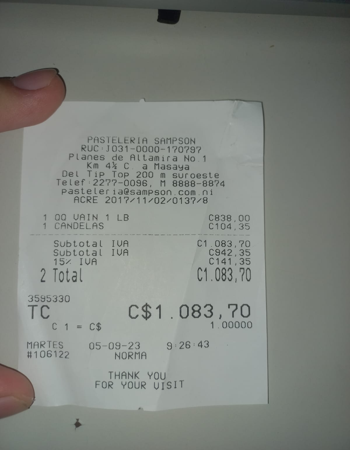

In [11]:

from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/drive/MyDrive/SROIE2019/Test.jpeg")
image = image.convert("RGB")
image.resize((350,450))

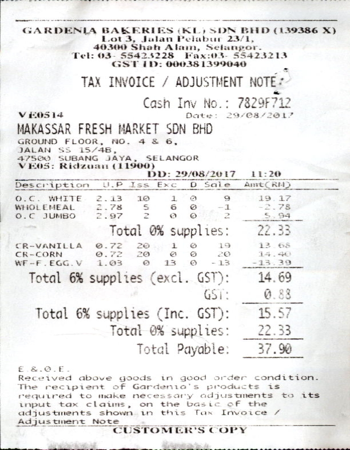

In [13]:
image2 = Image.open("/content/drive/MyDrive/SROIE2019/Test2.jpg")
image2 = image2.convert("RGB")
image2.resize((350,450))

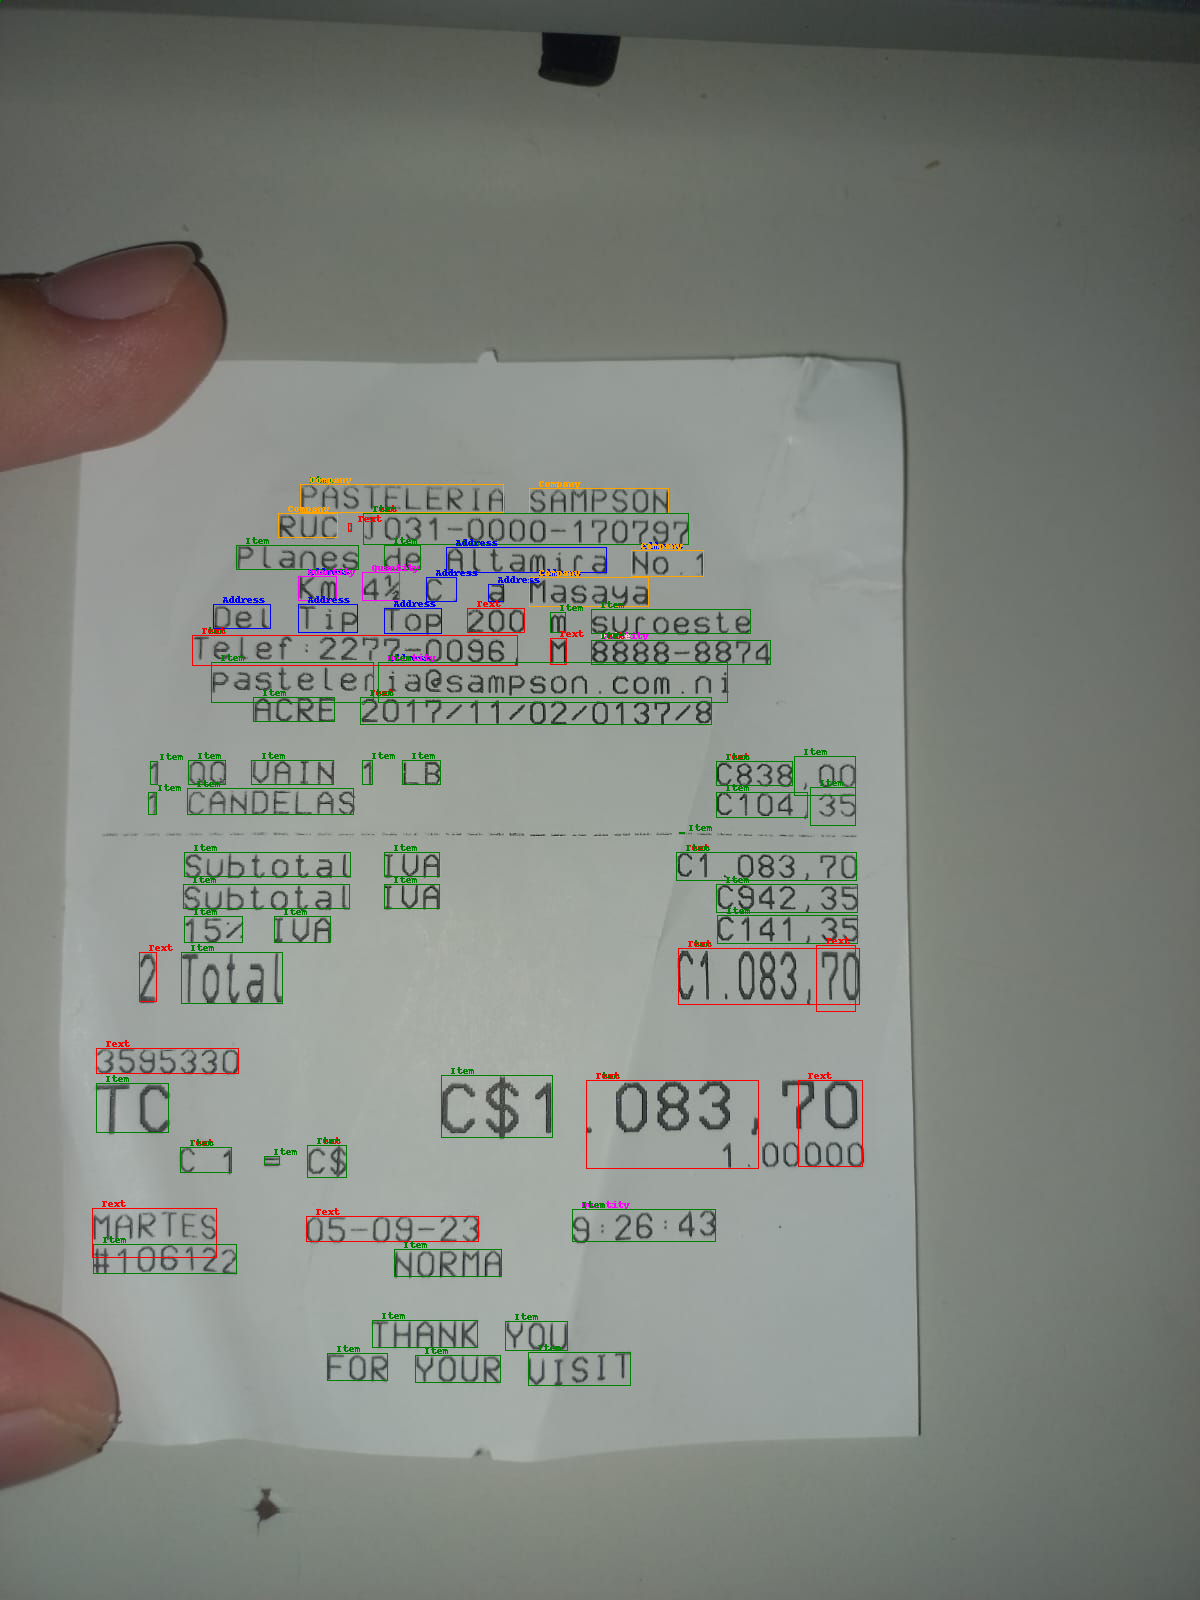

In [14]:
run_inference(image)

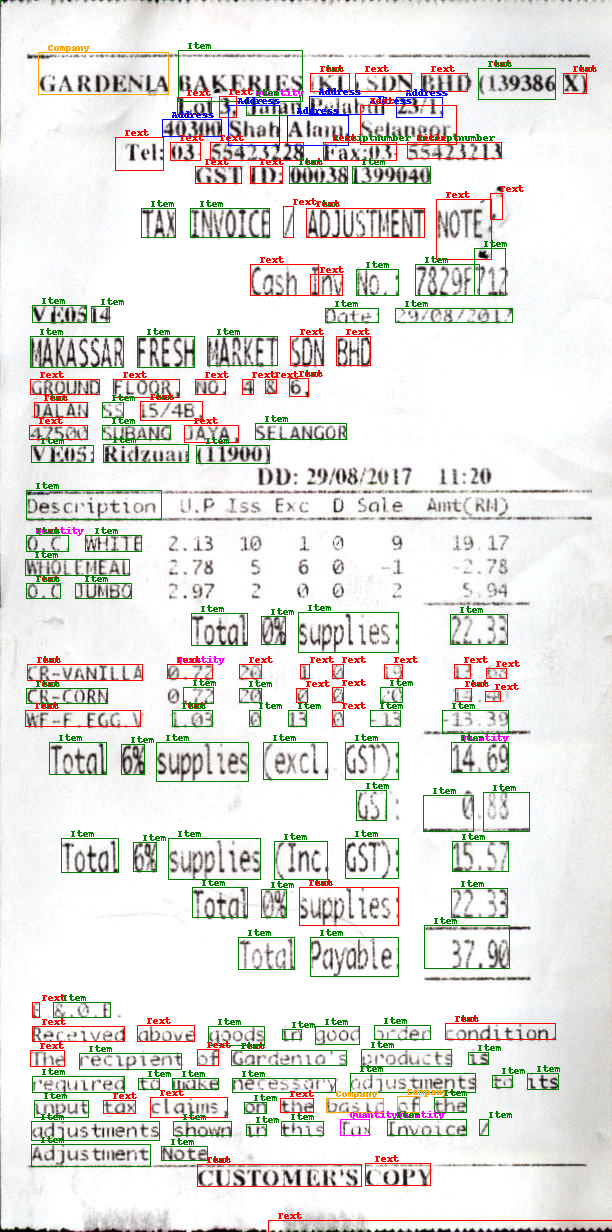

In [15]:
run_inference(image2)